In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
from sentence_transformers import SentenceTransformer, util
from sklearn.model_selection import train_test_split




In [3]:
training_images_path02 = '/workspaces/Shopee-Price-Match-Guarantee/00_source_data/shopee-product-matching/train_images02'
training_dataset =pd.read_csv('/workspaces/Shopee-Price-Match-Guarantee/00_source_data/shopee-product-matching/train.csv')
testing_dataset = pd.read_csv('/workspaces/Shopee-Price-Match-Guarantee/00_source_data/shopee-product-matching/test.csv')

In [4]:
training_dataset.head(10)

,posting_id,image,image_phash,title,label_group
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069
5,train_2464356923,0013e7355ffc5ff8fb1ccad3e42d92fe.jpg,bbd097a7870f4a50,CELANA WANITA (BB 45-84 KG)Harem wanita (bisa...,2660605217
6,train_1802986387,00144a49c56599d45354a1c28104c039.jpg,f815c9bb833ab4c8,Jubah anak size 1-12 thn,1835033137
7,train_1806152124,0014f61389cbaa687a58e38a97b6383d.jpg,eea7e1c0c04da33d,KULOT PLISKET SALUR /CANDY PLISKET /WISH KULOT...,1565741687
8,train_86570404,0019a3c6755a194cb2e2c12bfc63972e.jpg,ea9af4f483249972,"[LOGU] Tempelan kulkas magnet angka, tempelan ...",2359912463
9,train_831680791,001be52b2beec40ddc1d2d7fc7a68f08.jpg,e1ce953d1a70618f,BIG SALE SEPATU PANTOFEL KULIT KEREN KERJA KAN...,2630990665


In [5]:
print("The length of the unique values of the column label group is : ", len(training_dataset['label_group'].unique()))

The length of the unique values of the column label group is :  11014


In [6]:
grouped_label = training_dataset.groupby('label_group')

In [7]:
grouped_label.head()

,posting_id,image,image_phash,title,label_group
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069
...,...,...,...,...,...
34244,train_945815402,fff1222750374ddbed82b17c8bd2766d.jpg,b0cbce308fcdcc64,Baterai Batre Battery Xiaomi Redmi Note 3 BM46...,3091541662
34245,train_4028265689,fff1c07ceefc2c970a7964cfb81981c5.jpg,e3cd72389f248f21,Masker Bahan Kain Spunbond Non Woven 75 gsm 3 ...,3776555725
34246,train_769054909,fff401691371bdcb382a0d9075dfea6a.jpg,be86851f72e2853c,MamyPoko Pants Royal Soft - S 70 - Popok Celana,2736479533
34248,train_3630949769,fff51b87916dbfb6d0f8faa01bee67b8.jpg,e3b13bd1d896c05c,"Kaldu NON MSG HALAL Mama Kamu Ayam Kampung , S...",1663538013


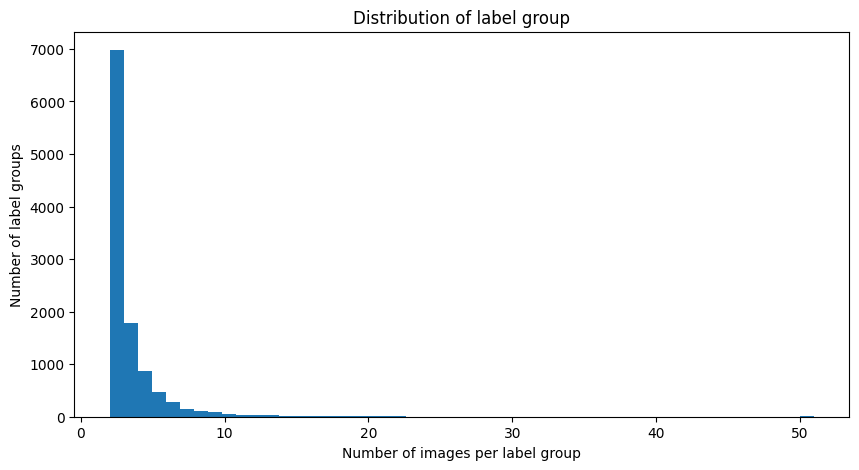

In [8]:
# create a graph to visualize the distribution of the label group
plt.figure(figsize=(10,5))
plt.hist(training_dataset['label_group'].value_counts(), bins=50)
# title
plt.title('Distribution of label group')
plt.xlabel('Number of images per label group')
plt.ylabel('Number of label groups')
plt.show()

In [10]:
# create embedding for the title
model = SentenceTransformer('paraphrase-distilroberta-base-v1')
title_embeddings = model.encode(training_dataset['title'].tolist(), show_progress_bar=True)

# create embedding for the image
image_embeddings = []
for i in training_dataset['image']:
    image_embeddings.append(np.array(Image.open(training_images_path02 + '/' + i)))

# create a function to find the most similar image
def find_similar_image(image_embeddings, image_index, top_n=5):
    # compute cosine-similarits
    cosine_scores = util.pytorch_cos_sim(image_embeddings[image_index], image_embeddings)[0]
    # get the top similar image's index
    cosine_scores = cosine_scores.cpu()
    top_results = np.argpartition(-cosine_scores, range(top_n))[0:top_n]
    return [(idx, cosine_scores[idx].item()) for idx in top_results if idx != image_index]

# create a function to find the most similar title
def find_similar_title(title_embeddings, title_index, top_n=5):
    # compute cosine-similarits
    cosine_scores = util.pytorch_cos_sim(title_embeddings[title_index], title_embeddings)[0]
    # get the top similar image's index
    cosine_scores = cosine_scores.cpu()
    top_results = np.argpartition(-cosine_scores, range(top_n))[0:top_n]
    return [(idx, cosine_scores[idx].item()) for idx in top_results if idx != title_index]

# create a function to find the most similar image and title
def find_similar_image_title(image_embeddings, title_embeddings, image_index, top_n=5):
    # compute cosine-similarits
    cosine_scores = util.pytorch_cos_sim(image_embeddings[image_index], image_embeddings)[0]
    cosine_scores += util.pytorch_cos_sim(title_embeddings[image_index], title_embeddings)[0]
    # get the top similar image's index
    cosine_scores = cosine_scores.cpu()
    top_results = np.argpartition(-cosine_scores, range(top_n))[0:top_n]
    return [(idx, cosine_scores[idx].item()) for idx in top_results if idx != image_index]

# create a function to find the most similar image and title
def find_similar_image_title(image_embeddings, title_embeddings, image_index, top_n=5):
    # compute cosine-similarits
    cosine_scores = util.pytorch_cos_sim(image_embeddings[image_index], image_embeddings)[0]
    cosine_scores += util.pytorch_cos_sim(title_embeddings[image_index], title_embeddings)[0]
    # get the top similar image's index
    cosine_scores = cosine_scores.cpu()
    top_results = np.argpartition(-cosine_scores, range(top_n))[0:top_n]
    return [(idx, cosine_scores[idx].item()) for idx in top_results if idx != image_index]

# create a function to find the most similar image and title

Batches: 100%|██████████| 1071/1071 [00:12<00:00, 85.21it/s] 


FileNotFoundError: [Errno 2] No such file or directory: '/workspaces/Shopee-Price-Match-Guarantee/00_source_data/shopee-product-matching/train_images02/0000a68812bc7e98c42888dfb1c07da0.jpg'

In [27]:
# group by label group and get the count of each label group
label_grouped_df = training_dataset.groupby('label_group')

In [6]:
model = SentenceTransformer('stsb-distilbert-base')


In [7]:
img_model = tf.keras.applications.MobileNet(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

2023-04-14 22:47:58.038765: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [8]:
def get_textEmbeddings(model,text):
    text_embedding = model.encode(text, convert_to_tensor=True)
    return text_embedding

In [18]:
SIZE = (224, 224)

def get_image_embeddings(model, image_path):
    image = tf.keras.preprocessing.image.load_img(image_path, target_size=SIZE)
    input_arr = tf.keras.preprocessing.image.img_to_array(image)
    input_arr = np.array([input_arr])
    img_embeddings = model(input_arr)
    mean_img_emb1 = np.mean(img_embeddings, axis=0)
    mean_img_emb2 = np.mean(mean_img_emb1, axis=0)
    mean_img_emb = np.mean(mean_img_emb2, axis=0)
    return mean_img_emb


In [22]:
# convert y to dataframe
y = training_dataset['label_group']

KeyError: 'label_group'

In [19]:
y = training_dataset.pop('label_group')
X = training_dataset

X_train,X_test,y_train,y_test = train_test_split(X,y,stratify=y,test_size=0.4,random_state=0)

KeyError: 'label_group'

In [11]:
# shape of training dataset
print("The shape of the training dataset is : ", training_dataset.shape)

The shape of the training dataset is :  (34250, 4)


In [12]:
# X train shape
print("The shape of the X train dataset is : ", X_train.shape)

The shape of the X train dataset is :  (20550, 4)


In [13]:
# print the shape of the X test dataset
print("The shape of the X test dataset is : ", X_test.shape)

The shape of the X test dataset is :  (13700, 4)


In [14]:
training_images_path = '/workspaces/Shopee-Price-Match-Guarantee/00_source_data/shopee-product-matching/train_images/'

In [17]:
text_embeddings={}
image_embeddings={}
for index, row in X_train.iterrows():
    txt_emb = get_textEmbeddings(model,str(row[3]))
    imagePath = training_images_path+row[1]
    img_emb = get_imageEmbeddings(img_model,imagePath)
    text_embeddings[row[0]] = txt_emb
    image_embeddings[row[0]] = img_emb

NameError: name 'size' is not defined

In [27]:
keyList=[]
cembList=[]
imageList=[]
titleList=[]
for index, row in X_train.iterrows():
    #start_time=time.time()
    txt_emb = text_embeddings[row[0]]
    print(np.shape(txt_emb))
    img_emb = image_embeddings[row[0]] 
    print(np.shape(img_emb))
    cmb_emb = np.concatenate((txt_emb,img_emb),axis=0)
    print(np.shape(cmb_emb))
    norm = np.linalg.norm(cmb_emb)
    cmb_emb_normal = cmb_emb/norm
    keyList.append(row[0])
    cembList.append(cmb_emb_normal)
    imageList.append(row[1])
    titleList.append(row[3])

NameError: name 'text_embeddings' is not defined